In [ ]:
import json
import re
from dotenv import load_dotenv
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tinker
from tinker import types
from tinker_cookbook.tokenizer_utils import get_tokenizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import time
from concurrent.futures import Future
import torch
from tinker.types.tensor_data import TensorData
from sentence_transformers import SentenceTransformer
import random
from bert_score import score as bertscore

In [30]:
BASE_MODEL = "meta-llama/Llama-3.1-8B-Instruct"
FINETUNE_PATH = "data/finetune_reverse.jsonl"
LABELS = ["A", "B", "C", "D"]
load_dotenv()
SEED = 42

In [31]:
def load_eval_examples(path: str) -> List[Dict]:
    """
    Load reverse RL evaluation examples from a JSONL file.

    Each line should have:
      - "prompt": the full text prompt to feed the model
      - "target": the reference meaning/definition text
    """
    examples: List[Dict] = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            # Expect keys: "prompt", "target"
            examples.append(ex)
    return examples


def example_to_prompt(ex: Dict) -> str:
    """
    For RL evaluation, the prompt is already fully constructed.
    """
    return ex["prompt"]


def example_to_target(ex: Dict) -> str:
    """
    Gold/reference meaning text for computing similarity/reward.
    """
    return ex["target"]


In [32]:
def parse_explanation(output_text: str) -> str:
    """
    For the reverse RL explanation task, we keep the full generated text,
    trimmed, so it can be compared against the reference meaning.
    """
    return output_text.strip()


In [33]:
_token_re = re.compile(r"\w+")

def _tokenize(text: str) -> List[str]:
    return _token_re.findall(text.lower())

def explanation_token_f1(pred: str, target: str) -> float:
    """
    Simple token-level F1 between prediction and target.
    """
    pred_tokens = _tokenize(pred)
    tgt_tokens  = _tokenize(target)

    if not pred_tokens or not tgt_tokens:
        return 0.0

    pred_counts: Dict[str, int] = {}
    tgt_counts: Dict[str, int] = {}
    for t in pred_tokens:
        pred_counts[t] = pred_counts.get(t, 0) + 1
    for t in tgt_tokens:
        tgt_counts[t] = tgt_counts.get(t, 0) + 1

    overlap = 0
    for t, c in pred_counts.items():
        if t in tgt_counts:
            overlap += min(c, tgt_counts[t])

    precision = overlap / max(len(pred_tokens), 1)
    recall    = overlap / max(len(tgt_tokens), 1)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


def exact_match(pred: str, target: str) -> bool:
    """
    Exact string match after light normalization:
    - lowercasing
    - strip whitespace
    """
    norm_pred   = " ".join(pred.lower().split())
    norm_target = " ".join(target.lower().split())
    return norm_pred == norm_target


def avg_word_length(texts: List[str]) -> float:
    """
    Average number of word tokens in a list of strings.
    """
    if not texts:
        return 0.0
    lengths = [len(_tokenize(t)) for t in texts]
    return float(np.mean(lengths))

def compute_bertscore_f1(preds: List[str], targets: List[str]) -> float | None:
    """
    Compute mean BERTScore F1 over (pred, target) pairs.
    Requires `bert_score` package. If not available, returns None.
    """
    if not preds or not targets:
        return 0.0

    try:
        from bert_score import score as bertscore
    except ImportError:
        # You can pip install bert_score to enable this
        print("[warn] bert_score not installed; skipping BERTScore metric.")
        return None

    P, R, F1 = bertscore(
        preds,
        targets,
        lang="en",
        rescale_with_baseline=True,  # common setting
    )
    return float(F1.mean().item())


In [34]:
def evaluate_rl(
    sampling_client: tinker.SamplingClient,
    model_name: str,
    jsonl_path: str,
    max_examples: int | None = None,
) -> Dict[str, Any]:
    """
    Evaluate a model on the reverse explanation task.

    - Reads eval_reverse_rl.jsonl (prompt + target).
    - Generates an explanation for each prompt.
    - Computes:
        * mean token-level F1
        * mean BERTScore F1 (if bert_score installed)
        * exact-match rate
        * average predicted length (words)
    """
    examples = load_eval_examples(jsonl_path)
    if max_examples is not None:
        examples = examples[:max_examples]

    tokenizer = get_tokenizer(model_name)
    sampling_params = types.SamplingParams(
        max_tokens=64,      # allow short explanation
        temperature=0.0,    # deterministic for eval
        top_p=1.0,
        stop=["\n"],        # stop at newline
    )

    token_f1_scores: List[float] = []
    exact_matches: List[bool] = []
    preds: List[str] = []
    targets: List[str] = []

    for ex in examples:
        prompt_text = example_to_prompt(ex)
        target_text = example_to_target(ex)

        tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        model_input = types.ModelInput.from_ints(tokens=tokens)

        result = sampling_client.sample(
            prompt=model_input,
            sampling_params=sampling_params,
            num_samples=1,
        ).result()

        gen_tokens = result.sequences[0].tokens
        gen_text   = tokenizer.decode(gen_tokens)
        pred_text  = parse_explanation(gen_text)

        f1 = explanation_token_f1(pred_text, target_text)

        token_f1_scores.append(f1)
        exact_matches.append(exact_match(pred_text, target_text))
        preds.append(pred_text)
        targets.append(target_text)

    mean_f1 = float(np.mean(token_f1_scores)) if token_f1_scores else 0.0
    exact_match_rate = float(np.mean(exact_matches)) if exact_matches else 0.0
    avg_pred_len = avg_word_length(preds)

    mean_bertscore_f1 = compute_bertscore_f1(preds, targets)

    metrics: Dict[str, Any] = {
        "mean_f1": mean_f1,
        "mean_bertscore_f1": mean_bertscore_f1,
        "exact_match_rate": exact_match_rate,
        "avg_pred_length_words": avg_pred_len,
        "token_f1_scores": token_f1_scores,
        "preds": preds,
        "targets": targets,
    }
    return metrics

In [35]:
def eval_baseline(jsonl_path: str, log_path: str) -> None:
    """
    Evaluate the BASE_MODEL on the reverse RL eval set.
    """
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(base_model=BASE_MODEL)

    metrics = evaluate_reverse_rl(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,
        jsonl_path=jsonl_path,
    )

    print("=== BASELINE REVERSE SEMANTICS RESULTS ===")
    print(f"Mean token-F1 vs target meaning: {metrics['mean_f1']:.4f}")

    if metrics["mean_bertscore_f1"] is not None:
        print(f"Mean BERTScore F1: {metrics['mean_bertscore_f1']:.4f}")
    else:
        print("Mean BERTScore F1: (bert_score not available)")

    print(f"Exact match rate: {metrics['exact_match_rate']:.4f}")
    print(f"Average predicted length (words): {metrics['avg_pred_length_words']:.2f}")

    # ---- Save metrics to JSON ----
    out_path = Path(log_path)
    out_path.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
    print(f"\nSaved baseline reverse-RL metrics to {out_path}")

In [36]:
def eval_finetuned(jsonl_path: str, model_path: str, log_path: str) -> None:
    """
    Evaluate a finetuned / RL-tuned model (given sampler weights path)
    on the reverse RL eval set.
    """
    service_client = tinker.ServiceClient()
    sampling_client = service_client.create_sampling_client(model_path=model_path)

    metrics = evaluate_reverse_rl(
        sampling_client=sampling_client,
        model_name=BASE_MODEL,  # tokenizer based on base model name
        jsonl_path=jsonl_path,
    )

    print("=== FINETUNED REVERSE SEMANTICS RESULTS ===")
    print(f"Mean token-F1 vs target meaning: {metrics['mean_f1']:.4f}")

    if metrics["mean_bertscore_f1"] is not None:
        print(f"Mean BERTScore F1: {metrics['mean_bertscore_f1']:.4f}")
    else:
        print("Mean BERTScore F1: (bert_score not available)")

    print(f"Exact match rate: {metrics['exact_match_rate']:.4f}")
    print(f"Average predicted length (words): {metrics['avg_pred_length_words']:.2f}")
    
    # ---- Save metrics to JSON ----
    out_path = Path(log_path)
    out_path.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
    print(f"\nSaved baseline reverse-RL metrics to {out_path}")

In [37]:
def load_finetune_examples(path: str):
    """
    Load reverse finetuning (or RL pretraining) examples from a JSONL file.

    Each line should have:
      - "prompt": the input text
      - "completion": the target explanation text
    """
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            ex = json.loads(line)
            examples.append(ex)
    return examples


In [38]:
def make_datums(examples, tokenizer) -> List[types.Datum]:
    """
    Turn (prompt, completion_text) into Tinker Datums.

    We feed the full prompt + completion, but only
    put loss on the completion token(s).
    """
    datums: List[types.Datum] = []

    for ex in examples:
        prompt_text = ex["prompt"]
        completion_text = ex["completion"]  # explanation text for reverse RL SFT

        # Encode prompt with specials
        prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
        prompt_weights = [0] * len(prompt_tokens)

        # Encode completion (no specials)
        # Add a leading space so the completion starts on a fresh token boundary.
        completion_tokens = tokenizer.encode(" " + completion_text, add_special_tokens=False)
        completion_weights = [1] * len(completion_tokens)

        tokens = prompt_tokens + completion_tokens
        weights = prompt_weights + completion_weights

        # Standard LM shifting: predict each token from previous.
        input_tokens = tokens[:-1]
        target_tokens = tokens[1:]
        target_weights = weights[1:]

        datum = types.Datum(
            model_input=types.ModelInput.from_ints(tokens=input_tokens),
            loss_fn_inputs=dict(
                target_tokens=target_tokens,
                weights=target_weights,
            ),
        )
        datums.append(datum)

    return datums


In [39]:
def batch_iter(datums: List[types.Datum], batch_size: int):
    n = len(datums)
    idxs = np.arange(n)
    np.random.shuffle(idxs)
    for i in range(0, n, batch_size):
        batch_idx = idxs[i : i + batch_size]
        yield [datums[j] for j in batch_idx]

In [40]:
eval_baseline("data/eval_reverse.jsonl", "logs/baseline_metrics.json")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\golde\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\golde\.cache\huggingface\hub\models--roberta-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== BASELINE REVERSE SEMANTICS RESULTS ===
Mean token-F1 vs target meaning: 0.0676
Mean BERTScore F1: -0.8129
Exact match rate: 0.0000
Average predicted length (words): 19.17

Saved baseline reverse-RL metrics to logs\baseline_metrics.json


In [41]:
# Supervised fine-tuning (SFT) for the reverse explanation task

service_client = tinker.ServiceClient()
training_client = service_client.create_lora_training_client(base_model=BASE_MODEL)
tokenizer = training_client.get_tokenizer()

examples = load_finetune_examples(FINETUNE_PATH)
datums = make_datums(examples, tokenizer)

RUN_ID = "reverse_semantic_sft_full"
LOG_DIR = Path("logs/{}".format(RUN_ID))
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

num_epochs = 4
batch_size = 16
learning_rate = 1e-4
global_step = 0

for epoch in range(1, num_epochs + 1):
    print(f"=== Epoch {epoch}/{num_epochs} ===")

    for batch in batch_iter(datums, batch_size=batch_size):
        global_step += 1

        fwdbwd_fut = training_client.forward_backward(batch, "cross_entropy")
        optim_fut = training_client.optim_step(
            types.AdamParams(
                learning_rate=learning_rate,
                beta1=0.89,
                beta2=0.99,
                eps=1e-8,
            )
        )

        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        # Built-in loss metric
        loss_sum = fwdbwd_res.metrics["loss:sum"]

        # Compute total number of *weighted* tokens for a mean NLL
        total_tokens = 0
        for d in batch:
            w = d.loss_fn_inputs["weights"]  # list or TensorData
            if hasattr(w, "data"):           # handle TensorData just in case
                w_np = np.array(w.data)
            else:
                w_np = np.array(w)
            total_tokens += (w_np > 0).sum()

        mean_nll = float(loss_sum / (total_tokens + 1e-8))

        record = {
            "step": global_step,
            "epoch": epoch,
            "train_loss_sum": float(loss_sum),
            "train_mean_nll": mean_nll,
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(record) + "\n")

        if global_step % 5 == 0:
            print(
                f"step {global_step} | "
                f"train_loss_sum={loss_sum:.4f} | "
                f"train_mean_nll={mean_nll:.4f}"
            )

# 1) Sampler weights – for evaluation
sft_resp_sampler = await training_client.save_weights_for_sampler(name=RUN_ID)
print("Saved SFT sampler weights at:", sft_resp_sampler.path)

# 2) Full training state – for RL initialization
sft_resp_state = await training_client.save_state(name=RUN_ID)
print("Saved full SFT training state at:", sft_resp_state.path)

=== Epoch 1/4 ===
step 5 | train_loss_sum=448.4580 | train_mean_nll=2.1770
step 10 | train_loss_sum=307.7419 | train_mean_nll=1.7892
step 15 | train_loss_sum=285.1922 | train_mean_nll=1.6678
step 20 | train_loss_sum=218.2108 | train_mean_nll=1.3553
step 25 | train_loss_sum=269.5585 | train_mean_nll=1.5316
step 30 | train_loss_sum=237.7463 | train_mean_nll=1.2068
step 35 | train_loss_sum=183.2991 | train_mean_nll=1.0356
=== Epoch 2/4 ===
step 40 | train_loss_sum=111.6367 | train_mean_nll=0.6379
step 45 | train_loss_sum=91.7973 | train_mean_nll=0.4456
step 50 | train_loss_sum=88.8421 | train_mean_nll=0.5588
step 55 | train_loss_sum=71.5172 | train_mean_nll=0.4232
step 60 | train_loss_sum=53.3132 | train_mean_nll=0.2748
step 65 | train_loss_sum=91.6687 | train_mean_nll=0.4850
step 70 | train_loss_sum=41.6835 | train_mean_nll=0.2290
step 75 | train_loss_sum=28.9149 | train_mean_nll=0.1606
=== Epoch 3/4 ===
step 80 | train_loss_sum=28.1610 | train_mean_nll=0.1591
step 85 | train_loss_sum=23

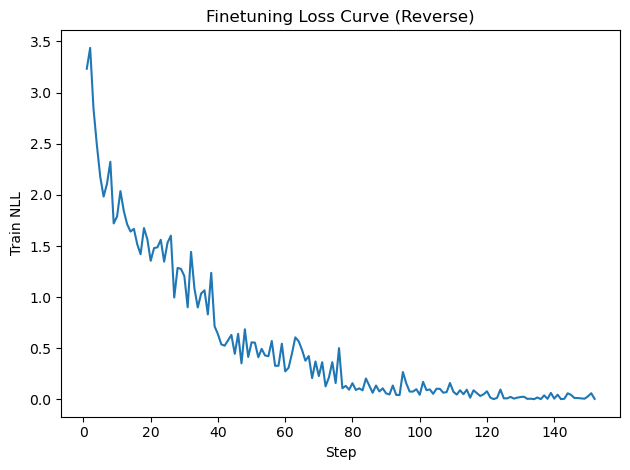

In [42]:
metrics_path = f"logs/{RUN_ID}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["train_mean_nll"])
plt.xlabel("Step")
plt.ylabel("Train NLL")
plt.title("Finetuning Loss Curve (Reverse)")
plt.tight_layout()
plt.show()

In [43]:
eval_finetuned(
    "data/eval_reverse.jsonl",
    str(sft_resp_sampler.path),
    f"logs/{RUN_ID}/finetuned_metrics.json"
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== FINETUNED REVERSE SEMANTICS RESULTS ===
Mean token-F1 vs target meaning: 0.2425
Mean BERTScore F1: 0.2081
Exact match rate: 0.0000
Average predicted length (words): 51.90

Saved baseline reverse-RL metrics to logs\reverse_semantic_sft_full\finetuned_metrics.json


In [48]:
def compute_reward(pred: str, target: str) -> float:
    """
    Turn explanation quality into a scalar reward.
    You can tweak scaling or add penalties here.
    """
    base_score = explanation_token_f1(pred, target)  # in [0, 1]
    return float(base_score)

In [56]:
# Small, fast sentence encoder
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8))

# Simple cache so we don't recompute target embeddings every time
_target_emb_cache: dict[str, np.ndarray] = {}

def _get_target_emb(text: str) -> np.ndarray:
    if text in _target_emb_cache:
        return _target_emb_cache[text]
    emb = emb_model.encode([text], convert_to_numpy=True, normalize_embeddings=True)[0]
    _target_emb_cache[text] = emb
    return emb

def compute_reward_similarity(pred: str, target: str) -> float:
    """
    Smooth reward in [0,1] based on embedding cosine similarity.

    This is *not* used as the default RL reward (because it hurt F1),
    but is useful for ablation experiments.
    """
    pred_emb = emb_model.encode([pred], convert_to_numpy=True, normalize_embeddings=True)[0]
    tgt_emb  = _get_target_emb(target)

    sim = cosine_sim(pred_emb, tgt_emb)
    # cosine is usually in [0,1] with normalized embeddings; clip for safety
    return float(np.clip(sim, 0.0, 1.0))


In [55]:
def compute_reward_hybrid(pred: str, target: str) -> float:
    """
    Hybrid reward: F1 is the main signal, semantic similarity is a small bonus.

    R = 0.8 * F1 + 0.2 * semantic_cosine

    This keeps you aligned with the F1 evaluation metric while allowing
    some flexibility for paraphrasing. Use as an *alternative* RL run,
    not the primary one.
    """
    f1  = explanation_token_f1(pred, target)    # token-level F1 in [0,1]
    sem = compute_reward_similarity(pred, target) # cosine in [0,1]

    # F1 dominates; semantic is a small nudge
    base = 0.8 * f1 + 0.2 * sem

    # Very small style penalty for excessive verbosity
    target_len = len(target.split())
    pred_len   = len(pred.split())

    penalty = 0.0
    # Mild penalty if prediction is way longer than target
    if pred_len > 2 * target_len:
        penalty -= 0.05  # keep this tiny so F1 still dominates

    reward = base + penalty
    return float(np.clip(reward, 0.0, 1.0))

In [ ]:
# -------------- RL hyperparams --------------
BATCH_SIZE    = 64      # prompts per batch
GROUP_SIZE    = 4       # samples per prompt (GRPO-style groups)
LEARNING_RATE = 1e-4    # similar to Tinker rl_loop default
MAX_TOKENS    = 64      # max tokens for explanation
N_EPOCHS      = 2       # start small; this is online RL
SAVE_EVERY    = 50      # save sampler weights every N steps

# -------------- Load RL training examples --------------
# Re-use existing loader: {"prompt": ..., "completion": ...}
rl_examples = load_finetune_examples(FINETUNE_PATH)
n_examples  = len(rl_examples)
print(f"Loaded {n_examples} RL examples; batch size = {BATCH_SIZE}, group size = {GROUP_SIZE}.")

# -------------- Create training client starting from SFT --------------
service_client = tinker.ServiceClient()

# sft_resp_state.path should be the path returned by training_client.save_state(...) from SFT
training_client = service_client.create_training_client_from_state(sft_resp_state.path)

tokenizer = training_client.get_tokenizer()

sampling_params = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=0.5,
    top_p=0.9,
    stop=["\n"],
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

RUN_ID_F1 = "reverse_f1_grpo"   # renamed for clarity
LOG_DIR = Path(f"logs/{RUN_ID_F1}")
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

global_step = 0

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n=== RL Epoch {epoch}/{N_EPOCHS} ===")

    # Shuffle examples each epoch
    idxs = np.arange(n_examples)
    np.random.shuffle(idxs)

    # Iterate over all examples, including the last partial batch
    for start in range(0, n_examples, BATCH_SIZE):
        t_start = time.time()
        global_step += 1

        end = min(start + BATCH_SIZE, n_examples)
        batch_idxs = idxs[start:end]
        batch_examples = [rl_examples[i] for i in batch_idxs]

        # We'll collect rollouts here
        batch_futures: List[List[Future[types.SampleResponse]]] = []
        batch_prompt_tokens: List[List[int]] = []
        batch_targets: List[str] = []

        # --------- 1) Create a sampler from current training weights ---------
        sampling_path = training_client.save_weights_for_sampler(
            name=f"rl_step_{global_step:06d}"
        ).result().path
        sampling_client = service_client.create_sampling_client(model_path=sampling_path)

        # --------- 2) Launch sampling (GROUP_SIZE per prompt) ---------
        for ex in batch_examples:
            prompt_text = ex["prompt"]
            target_text = ex["completion"]  # gold meaning for reward

            prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
            model_input   = types.ModelInput.from_ints(tokens=prompt_tokens)

            sample_futures: List[Future[types.SampleResponse]] = []
            for _ in range(GROUP_SIZE):
                fut = sampling_client.sample(
                    prompt=model_input,
                    num_samples=1,
                    sampling_params=sampling_params,
                )
                sample_futures.append(fut)

            batch_futures.append(sample_futures)
            batch_prompt_tokens.append(prompt_tokens)
            batch_targets.append(target_text)

        # --------- 3) Gather samples, compute rewards, advantages ---------
        training_datums: List[types.Datum] = []
        batch_rewards: List[float] = []

        for sample_futures, prompt_tokens, target_text in zip(
            batch_futures, batch_prompt_tokens, batch_targets
        ):
            group_rewards: List[float] = []
            group_tokens: List[List[int]] = []
            group_logprobs: List[List[float]] = []
            group_ob_lens: List[int] = []

            for fut in sample_futures:
                sample_result = fut.result()
                seq = sample_result.sequences[0]
                sampled_tokens = seq.tokens
                sampled_logprobs = seq.logprobs
                assert sampled_logprobs is not None

                all_tokens = prompt_tokens + sampled_tokens

                # Observation length: all prompt tokens except the very first BOS
                ob_len = len(prompt_tokens) - 1

                # Decode only generated tokens for reward
                gen_text = tokenizer.decode(sampled_tokens)
                pred_text = parse_explanation(gen_text)

                # IMPORTANT: reward is F1-based (compute_reward = explanation_f1)
                reward = compute_reward(pred_text, target_text)

                group_tokens.append(all_tokens)
                group_logprobs.append(sampled_logprobs)
                group_ob_lens.append(ob_len)
                group_rewards.append(reward)

            # Group-relative baseline (GRPO-style)
            if len(group_rewards) == 0:
                continue

            group_mean = float(sum(group_rewards) / len(group_rewards))
            advantages = [r - group_mean for r in group_rewards]

            batch_rewards.append(group_mean)

            # If all advantages are 0, skip (no learning signal)
            if all(a == 0.0 for a in advantages):
                continue

            # --------- 4) Convert each sample in the group to a Datum ---------
            for tokens, logprob, advantage, ob_len in zip(
                group_tokens, group_logprobs, advantages, group_ob_lens
            ):
                # Standard LM shift
                input_tokens  = tokens[:-1]
                target_tokens = tokens[1:]

                # Sampling logprobs over whole prefix; 0s for prompt region,
                # then actual logprobs for generated region.
                all_logprobs = [0.0] * ob_len + list(logprob)
                if len(all_logprobs) < len(input_tokens):
                    all_logprobs += [0.0] * (len(input_tokens) - len(all_logprobs))
                all_logprobs = all_logprobs[: len(input_tokens)]

                # Advantages: 0 in prompt region, then constant advantage for generated region
                all_advantages = [0.0] * ob_len + [advantage] * (len(input_tokens) - ob_len)

                assert len(input_tokens) == len(target_tokens) == len(all_logprobs) == len(all_advantages), (
                    f"Length mismatch: "
                    f"input={len(input_tokens)}, target={len(target_tokens)}, "
                    f"logprobs={len(all_logprobs)}, adv={len(all_advantages)}"
                )

                datum = types.Datum(
                    model_input=types.ModelInput.from_ints(tokens=[int(t) for t in input_tokens]),
                    loss_fn_inputs={
                        "target_tokens": TensorData.from_torch(
                            torch.tensor(target_tokens, dtype=torch.long)
                        ),
                        "logprobs": TensorData.from_torch(
                            torch.tensor(all_logprobs, dtype=torch.float32)
                        ),
                        "advantages": TensorData.from_torch(
                            torch.tensor(all_advantages, dtype=torch.float32)
                        ),
                    },
                )
                training_datums.append(datum)

        # If no datums (e.g., all-zero rewards), just skip this step
        if not training_datums:
            print(f"step {global_step}: no RL datums (all-zero advantages), skipping.")
            continue

        # --------- 5) RL update with importance_sampling (policy gradient) ---------
        fwdbwd_fut = training_client.forward_backward(
            training_datums, loss_fn="importance_sampling"
        )
        optim_fut = training_client.optim_step(adam_params)

        # Block until both forward/backward and optimizer step finish
        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        mean_reward = float(sum(batch_rewards) / len(batch_rewards)) if batch_rewards else 0.0
        elapsed = time.time() - t_start

        # Simple logging
        rec = {
            "step": global_step,
            "epoch": epoch,
            "time/total": elapsed,
            "reward/mean": mean_reward,
            "n_datums": len(training_datums),
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        print(
            f"step {global_step} | epoch {epoch} | "
            f"mean_reward={mean_reward:.4f} | n_datums={len(training_datums)} | "
            f"time={elapsed:.2f}s"
        )

# Final save
grpo_f1_resp = await training_client.save_weights_for_sampler(name=RUN_ID_F1)
print("Finished RL training; final sampler weights:", grpo_f1_resp.path)


Loaded 605 RL examples; batch size = 64, group size = 4.

=== RL Epoch 1/2 ===
step 1 | epoch 1 | mean_reward=0.2415 | n_datums=248 | time=15.84s
step 2 | epoch 1 | mean_reward=0.2725 | n_datums=252 | time=24.16s
step 3 | epoch 1 | mean_reward=0.2877 | n_datums=256 | time=16.70s
step 4 | epoch 1 | mean_reward=0.2888 | n_datums=256 | time=22.54s
step 5 | epoch 1 | mean_reward=0.3163 | n_datums=248 | time=14.79s
step 6 | epoch 1 | mean_reward=0.3514 | n_datums=244 | time=15.76s
step 7 | epoch 1 | mean_reward=0.3997 | n_datums=240 | time=16.81s
step 8 | epoch 1 | mean_reward=0.4006 | n_datums=252 | time=13.76s
step 9 | epoch 1 | mean_reward=0.5297 | n_datums=220 | time=13.56s
step 10 | epoch 1 | mean_reward=0.7920 | n_datums=72 | time=10.62s

=== RL Epoch 2/2 ===
step 11 | epoch 2 | mean_reward=0.8325 | n_datums=132 | time=17.42s
step 12 | epoch 2 | mean_reward=0.7871 | n_datums=88 | time=12.54s
step 13 | epoch 2 | mean_reward=0.9352 | n_datums=48 | time=12.28s
step 14 | epoch 2 | mean_re

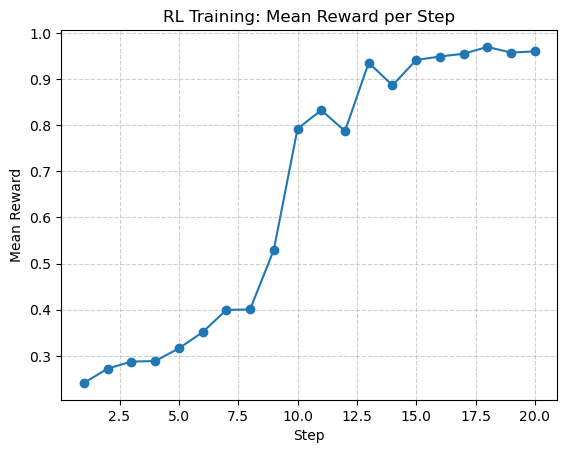

In [52]:
metrics_path = f"logs/{RUN_ID_F1}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["reward/mean"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("RL Training: Mean Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [54]:
eval_finetuned(
    "data/eval_reverse.jsonl",
    str(grpo_f1_resp.path),
    f"logs/{RUN_ID_F1}/reinforced_metrics.json"
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== FINETUNED REVERSE SEMANTICS RESULTS ===
Mean token-F1 vs target meaning: 0.8053
Mean BERTScore F1: -0.0673
Exact match rate: 0.0000
Average predicted length (words): 8.96

Saved baseline reverse-RL metrics to logs\reverse_f1_grpo\reinforced_metrics.json


In [58]:
# -------------- RL hyperparams --------------
BATCH_SIZE    = 64      # prompts per batch
GROUP_SIZE    = 4       # samples per prompt (GRPO-style groups)
LEARNING_RATE = 1e-4    # similar to Tinker rl_loop default
MAX_TOKENS    = 64      # max tokens for explanation
N_EPOCHS      = 2       # start small; this is online RL
SAVE_EVERY    = 50      # save sampler weights every N steps

# -------------- Load RL training examples --------------
# Re-use existing loader: {"prompt": ..., "completion": ...}
rl_examples = load_finetune_examples(FINETUNE_PATH)
n_examples  = len(rl_examples)
print(f"Loaded {n_examples} RL examples; batch size = {BATCH_SIZE}, group size = {GROUP_SIZE}.")

# -------------- Create training client starting from SFT --------------
service_client = tinker.ServiceClient()

# sft_resp_state.path should be the path returned by training_client.save_state(...) from SFT
training_client = service_client.create_training_client_from_state(sft_resp_state.path)

tokenizer = training_client.get_tokenizer()

sampling_params = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=0.5,
    top_p=0.9,
    stop=["\n"],
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

RUN_ID_SIM = "reverse_similarity_grpo"   # renamed for clarity
LOG_DIR = Path(f"logs/{RUN_ID_SIM}")
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

global_step = 0

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n=== RL Epoch {epoch}/{N_EPOCHS} ===")

    # Shuffle examples each epoch
    idxs = np.arange(n_examples)
    np.random.shuffle(idxs)

    # Iterate over all examples, including the last partial batch
    for start in range(0, n_examples, BATCH_SIZE):
        t_start = time.time()
        global_step += 1

        end = min(start + BATCH_SIZE, n_examples)
        batch_idxs = idxs[start:end]
        batch_examples = [rl_examples[i] for i in batch_idxs]

        # We'll collect rollouts here
        batch_futures: List[List[Future[types.SampleResponse]]] = []
        batch_prompt_tokens: List[List[int]] = []
        batch_targets: List[str] = []

        # --------- 1) Create a sampler from current training weights ---------
        sampling_path = training_client.save_weights_for_sampler(
            name=f"rl_step_{global_step:06d}"
        ).result().path
        sampling_client = service_client.create_sampling_client(model_path=sampling_path)

        # --------- 2) Launch sampling (GROUP_SIZE per prompt) ---------
        for ex in batch_examples:
            prompt_text = ex["prompt"]
            target_text = ex["completion"]  # gold meaning for reward

            prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
            model_input   = types.ModelInput.from_ints(tokens=prompt_tokens)

            sample_futures: List[Future[types.SampleResponse]] = []
            for _ in range(GROUP_SIZE):
                fut = sampling_client.sample(
                    prompt=model_input,
                    num_samples=1,
                    sampling_params=sampling_params,
                )
                sample_futures.append(fut)

            batch_futures.append(sample_futures)
            batch_prompt_tokens.append(prompt_tokens)
            batch_targets.append(target_text)

        # --------- 3) Gather samples, compute rewards, advantages ---------
        training_datums: List[types.Datum] = []
        batch_rewards: List[float] = []

        for sample_futures, prompt_tokens, target_text in zip(
            batch_futures, batch_prompt_tokens, batch_targets
        ):
            group_rewards: List[float] = []
            group_tokens: List[List[int]] = []
            group_logprobs: List[List[float]] = []
            group_ob_lens: List[int] = []

            for fut in sample_futures:
                sample_result = fut.result()
                seq = sample_result.sequences[0]
                sampled_tokens = seq.tokens
                sampled_logprobs = seq.logprobs
                assert sampled_logprobs is not None

                all_tokens = prompt_tokens + sampled_tokens

                # Observation length: all prompt tokens except the very first BOS
                ob_len = len(prompt_tokens) - 1

                # Decode only generated tokens for reward
                gen_text = tokenizer.decode(sampled_tokens)
                pred_text = parse_explanation(gen_text)

                # IMPORTANT: reward is Cos-Sim-based
                reward = compute_reward_similarity(pred_text, target_text)

                group_tokens.append(all_tokens)
                group_logprobs.append(sampled_logprobs)
                group_ob_lens.append(ob_len)
                group_rewards.append(reward)

            # Group-relative baseline (GRPO-style)
            if len(group_rewards) == 0:
                continue

            group_mean = float(sum(group_rewards) / len(group_rewards))
            advantages = [r - group_mean for r in group_rewards]

            batch_rewards.append(group_mean)

            # If all advantages are 0, skip (no learning signal)
            if all(a == 0.0 for a in advantages):
                continue

            # --------- 4) Convert each sample in the group to a Datum ---------
            for tokens, logprob, advantage, ob_len in zip(
                group_tokens, group_logprobs, advantages, group_ob_lens
            ):
                # Standard LM shift
                input_tokens  = tokens[:-1]
                target_tokens = tokens[1:]

                # Sampling logprobs over whole prefix; 0s for prompt region,
                # then actual logprobs for generated region.
                all_logprobs = [0.0] * ob_len + list(logprob)
                if len(all_logprobs) < len(input_tokens):
                    all_logprobs += [0.0] * (len(input_tokens) - len(all_logprobs))
                all_logprobs = all_logprobs[: len(input_tokens)]

                # Advantages: 0 in prompt region, then constant advantage for generated region
                all_advantages = [0.0] * ob_len + [advantage] * (len(input_tokens) - ob_len)

                assert len(input_tokens) == len(target_tokens) == len(all_logprobs) == len(all_advantages), (
                    f"Length mismatch: "
                    f"input={len(input_tokens)}, target={len(target_tokens)}, "
                    f"logprobs={len(all_logprobs)}, adv={len(all_advantages)}"
                )

                datum = types.Datum(
                    model_input=types.ModelInput.from_ints(tokens=[int(t) for t in input_tokens]),
                    loss_fn_inputs={
                        "target_tokens": TensorData.from_torch(
                            torch.tensor(target_tokens, dtype=torch.long)
                        ),
                        "logprobs": TensorData.from_torch(
                            torch.tensor(all_logprobs, dtype=torch.float32)
                        ),
                        "advantages": TensorData.from_torch(
                            torch.tensor(all_advantages, dtype=torch.float32)
                        ),
                    },
                )
                training_datums.append(datum)

        # If no datums (e.g., all-zero rewards), just skip this step
        if not training_datums:
            print(f"step {global_step}: no RL datums (all-zero advantages), skipping.")
            continue

        # --------- 5) RL update with importance_sampling (policy gradient) ---------
        fwdbwd_fut = training_client.forward_backward(
            training_datums, loss_fn="importance_sampling"
        )
        optim_fut = training_client.optim_step(adam_params)

        # Block until both forward/backward and optimizer step finish
        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        mean_reward = float(sum(batch_rewards) / len(batch_rewards)) if batch_rewards else 0.0
        elapsed = time.time() - t_start

        # Simple logging
        rec = {
            "step": global_step,
            "epoch": epoch,
            "time/total": elapsed,
            "reward/mean": mean_reward,
            "n_datums": len(training_datums),
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        print(
            f"step {global_step} | epoch {epoch} | "
            f"mean_reward={mean_reward:.4f} | n_datums={len(training_datums)} | "
            f"time={elapsed:.2f}s"
        )

# Final save
grpo_sim_resp = await training_client.save_weights_for_sampler(name=RUN_ID_SIM)
print("Finished RL training; final sampler weights:", grpo_sim_resp.path)

Loaded 605 RL examples; batch size = 64, group size = 4.

=== RL Epoch 1/2 ===
step 1 | epoch 1 | mean_reward=0.7047 | n_datums=248 | time=20.33s
step 2 | epoch 1 | mean_reward=0.7521 | n_datums=256 | time=15.45s
step 3 | epoch 1 | mean_reward=0.7341 | n_datums=256 | time=19.77s
step 4 | epoch 1 | mean_reward=0.7629 | n_datums=256 | time=16.27s
step 5 | epoch 1 | mean_reward=0.7367 | n_datums=256 | time=15.11s
step 6 | epoch 1 | mean_reward=0.7674 | n_datums=256 | time=16.24s
step 7 | epoch 1 | mean_reward=0.7547 | n_datums=256 | time=16.60s
step 8 | epoch 1 | mean_reward=0.7424 | n_datums=256 | time=18.71s
step 9 | epoch 1 | mean_reward=0.7550 | n_datums=252 | time=16.81s
step 10 | epoch 1 | mean_reward=0.7559 | n_datums=116 | time=15.44s

=== RL Epoch 2/2 ===
step 11 | epoch 2 | mean_reward=0.7307 | n_datums=256 | time=15.82s
step 12 | epoch 2 | mean_reward=0.7504 | n_datums=256 | time=16.12s
step 13 | epoch 2 | mean_reward=0.7521 | n_datums=252 | time=18.15s
step 14 | epoch 2 | mean

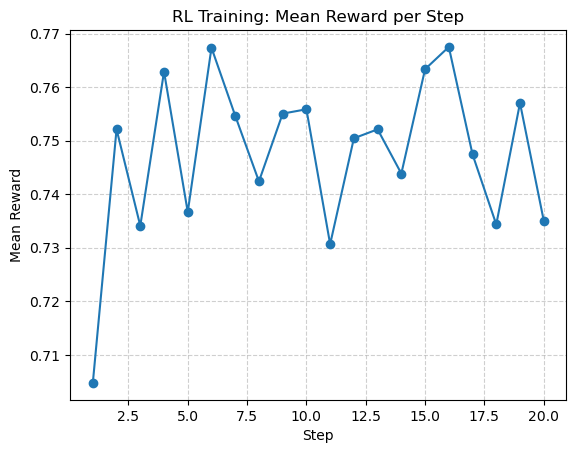

In [59]:
metrics_path = f"logs/{RUN_ID_SIM}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["reward/mean"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("RL Training: Mean Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [60]:
eval_finetuned(
    'data/eval_reverse.jsonl',
    str(grpo_sim_resp.path),
    f"logs/{RUN_ID_SIM}/reinforced_metrics.json"
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== FINETUNED REVERSE SEMANTICS RESULTS ===
Mean token-F1 vs target meaning: 0.2113
Mean BERTScore F1: 0.1693
Exact match rate: 0.0000
Average predicted length (words): 54.50

Saved baseline reverse-RL metrics to logs\reverse_similarity_grpo\reinforced_metrics.json


In [61]:
# -------------- RL hyperparams --------------
BATCH_SIZE    = 64      # prompts per batch
GROUP_SIZE    = 4       # samples per prompt (GRPO-style groups)
LEARNING_RATE = 1e-4    # similar to Tinker rl_loop default
MAX_TOKENS    = 64      # max tokens for explanation
N_EPOCHS      = 2       # start small; this is online RL
SAVE_EVERY    = 50      # save sampler weights every N steps

# -------------- Load RL training examples --------------
# Re-use existing loader: {"prompt": ..., "completion": ...}
rl_examples = load_finetune_examples(FINETUNE_PATH)
n_examples  = len(rl_examples)
print(f"Loaded {n_examples} RL examples; batch size = {BATCH_SIZE}, group size = {GROUP_SIZE}.")

# -------------- Create training client starting from SFT --------------
service_client = tinker.ServiceClient()

# sft_resp_state.path should be the path returned by training_client.save_state(...) from SFT
training_client = service_client.create_training_client_from_state(sft_resp_state.path)

tokenizer = training_client.get_tokenizer()

sampling_params = types.SamplingParams(
    max_tokens=MAX_TOKENS,
    temperature=0.5,
    top_p=0.9,
    stop=["\n"],
)

adam_params = types.AdamParams(
    learning_rate=LEARNING_RATE,
    beta1=0.9,
    beta2=0.95,
    eps=1e-8,
)

RUN_ID_HYB = "reverse_hybrid_grpo"   # renamed for clarity
LOG_DIR = Path(f"logs/{RUN_ID_HYB}")
LOG_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = LOG_DIR / "metrics.jsonl"

global_step = 0

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n=== RL Epoch {epoch}/{N_EPOCHS} ===")

    # Shuffle examples each epoch
    idxs = np.arange(n_examples)
    np.random.shuffle(idxs)

    # Iterate over all examples, including the last partial batch
    for start in range(0, n_examples, BATCH_SIZE):
        t_start = time.time()
        global_step += 1

        end = min(start + BATCH_SIZE, n_examples)
        batch_idxs = idxs[start:end]
        batch_examples = [rl_examples[i] for i in batch_idxs]

        # We'll collect rollouts here
        batch_futures: List[List[Future[types.SampleResponse]]] = []
        batch_prompt_tokens: List[List[int]] = []
        batch_targets: List[str] = []

        # --------- 1) Create a sampler from current training weights ---------
        sampling_path = training_client.save_weights_for_sampler(
            name=f"rl_step_{global_step:06d}"
        ).result().path
        sampling_client = service_client.create_sampling_client(model_path=sampling_path)

        # --------- 2) Launch sampling (GROUP_SIZE per prompt) ---------
        for ex in batch_examples:
            prompt_text = ex["prompt"]
            target_text = ex["completion"]  # gold meaning for reward

            prompt_tokens = tokenizer.encode(prompt_text, add_special_tokens=True)
            model_input   = types.ModelInput.from_ints(tokens=prompt_tokens)

            sample_futures: List[Future[types.SampleResponse]] = []
            for _ in range(GROUP_SIZE):
                fut = sampling_client.sample(
                    prompt=model_input,
                    num_samples=1,
                    sampling_params=sampling_params,
                )
                sample_futures.append(fut)

            batch_futures.append(sample_futures)
            batch_prompt_tokens.append(prompt_tokens)
            batch_targets.append(target_text)

        # --------- 3) Gather samples, compute rewards, advantages ---------
        training_datums: List[types.Datum] = []
        batch_rewards: List[float] = []

        for sample_futures, prompt_tokens, target_text in zip(
            batch_futures, batch_prompt_tokens, batch_targets
        ):
            group_rewards: List[float] = []
            group_tokens: List[List[int]] = []
            group_logprobs: List[List[float]] = []
            group_ob_lens: List[int] = []

            for fut in sample_futures:
                sample_result = fut.result()
                seq = sample_result.sequences[0]
                sampled_tokens = seq.tokens
                sampled_logprobs = seq.logprobs
                assert sampled_logprobs is not None

                all_tokens = prompt_tokens + sampled_tokens

                # Observation length: all prompt tokens except the very first BOS
                ob_len = len(prompt_tokens) - 1

                # Decode only generated tokens for reward
                gen_text = tokenizer.decode(sampled_tokens)
                pred_text = parse_explanation(gen_text)

                # IMPORTANT: reward is f1 & cos-sim hybrid based
                reward = compute_reward_hybrid(pred_text, target_text)

                group_tokens.append(all_tokens)
                group_logprobs.append(sampled_logprobs)
                group_ob_lens.append(ob_len)
                group_rewards.append(reward)

            # Group-relative baseline (GRPO-style)
            if len(group_rewards) == 0:
                continue

            group_mean = float(sum(group_rewards) / len(group_rewards))
            advantages = [r - group_mean for r in group_rewards]

            batch_rewards.append(group_mean)

            # If all advantages are 0, skip (no learning signal)
            if all(a == 0.0 for a in advantages):
                continue

            # --------- 4) Convert each sample in the group to a Datum ---------
            for tokens, logprob, advantage, ob_len in zip(
                group_tokens, group_logprobs, advantages, group_ob_lens
            ):
                # Standard LM shift
                input_tokens  = tokens[:-1]
                target_tokens = tokens[1:]

                # Sampling logprobs over whole prefix; 0s for prompt region,
                # then actual logprobs for generated region.
                all_logprobs = [0.0] * ob_len + list(logprob)
                if len(all_logprobs) < len(input_tokens):
                    all_logprobs += [0.0] * (len(input_tokens) - len(all_logprobs))
                all_logprobs = all_logprobs[: len(input_tokens)]

                # Advantages: 0 in prompt region, then constant advantage for generated region
                all_advantages = [0.0] * ob_len + [advantage] * (len(input_tokens) - ob_len)

                assert len(input_tokens) == len(target_tokens) == len(all_logprobs) == len(all_advantages), (
                    f"Length mismatch: "
                    f"input={len(input_tokens)}, target={len(target_tokens)}, "
                    f"logprobs={len(all_logprobs)}, adv={len(all_advantages)}"
                )

                datum = types.Datum(
                    model_input=types.ModelInput.from_ints(tokens=[int(t) for t in input_tokens]),
                    loss_fn_inputs={
                        "target_tokens": TensorData.from_torch(
                            torch.tensor(target_tokens, dtype=torch.long)
                        ),
                        "logprobs": TensorData.from_torch(
                            torch.tensor(all_logprobs, dtype=torch.float32)
                        ),
                        "advantages": TensorData.from_torch(
                            torch.tensor(all_advantages, dtype=torch.float32)
                        ),
                    },
                )
                training_datums.append(datum)

        # If no datums (e.g., all-zero rewards), just skip this step
        if not training_datums:
            print(f"step {global_step}: no RL datums (all-zero advantages), skipping.")
            continue

        # --------- 5) RL update with importance_sampling (policy gradient) ---------
        fwdbwd_fut = training_client.forward_backward(
            training_datums, loss_fn="importance_sampling"
        )
        optim_fut = training_client.optim_step(adam_params)

        # Block until both forward/backward and optimizer step finish
        fwdbwd_res = fwdbwd_fut.result()
        optim_fut.result()

        mean_reward = float(sum(batch_rewards) / len(batch_rewards)) if batch_rewards else 0.0
        elapsed = time.time() - t_start

        # Simple logging
        rec = {
            "step": global_step,
            "epoch": epoch,
            "time/total": elapsed,
            "reward/mean": mean_reward,
            "n_datums": len(training_datums),
        }
        with metrics_path.open("a", encoding="utf-8") as f:
            f.write(json.dumps(rec) + "\n")

        print(
            f"step {global_step} | epoch {epoch} | "
            f"mean_reward={mean_reward:.4f} | n_datums={len(training_datums)} | "
            f"time={elapsed:.2f}s"
        )

# Final save
grpo_hyb_resp = await training_client.save_weights_for_sampler(name=RUN_ID_HYB)
print("Finished RL training; final sampler weights:", grpo_hyb_resp.path)

Loaded 605 RL examples; batch size = 64, group size = 4.

=== RL Epoch 1/2 ===
step 1 | epoch 1 | mean_reward=0.2933 | n_datums=256 | time=17.27s
step 2 | epoch 1 | mean_reward=0.3300 | n_datums=256 | time=15.11s
step 3 | epoch 1 | mean_reward=0.3199 | n_datums=256 | time=14.94s
step 4 | epoch 1 | mean_reward=0.3041 | n_datums=256 | time=15.57s
step 5 | epoch 1 | mean_reward=0.3141 | n_datums=256 | time=15.62s
step 6 | epoch 1 | mean_reward=0.2937 | n_datums=256 | time=16.53s
step 7 | epoch 1 | mean_reward=0.3598 | n_datums=256 | time=14.96s
step 8 | epoch 1 | mean_reward=0.3298 | n_datums=256 | time=16.67s
step 9 | epoch 1 | mean_reward=0.3372 | n_datums=256 | time=15.33s
step 10 | epoch 1 | mean_reward=0.3263 | n_datums=108 | time=11.12s

=== RL Epoch 2/2 ===
step 11 | epoch 2 | mean_reward=0.3567 | n_datums=184 | time=15.65s
step 12 | epoch 2 | mean_reward=0.3352 | n_datums=152 | time=15.35s
step 13 | epoch 2 | mean_reward=0.3604 | n_datums=180 | time=16.21s
step 14 | epoch 2 | mean

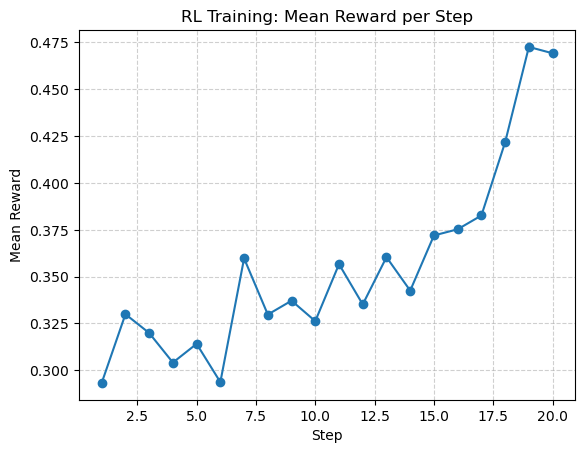

In [62]:
metrics_path = f"logs/{RUN_ID_HYB}/metrics.jsonl"
df = pd.read_json(metrics_path, lines=True)

plt.figure()
plt.plot(df["step"], df["reward/mean"], marker="o", linestyle="-")
plt.xlabel("Step")
plt.ylabel("Mean Reward")
plt.title("RL Training: Mean Reward per Step")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [63]:
eval_finetuned(
    'data/eval_reverse.jsonl',
    str(grpo_hyb_resp.path),
    f"logs/{RUN_ID_HYB}/reinforced_metrics.json"
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== FINETUNED REVERSE SEMANTICS RESULTS ===
Mean token-F1 vs target meaning: 0.3904
Mean BERTScore F1: 0.0695
Exact match rate: 0.0000
Average predicted length (words): 20.68

Saved baseline reverse-RL metrics to logs\reverse_hybrid_grpo\reinforced_metrics.json


In [64]:
def make_sampling_client(service_client, model_spec: Dict):
    """
    model_spec format:
      {
        "name": "baseline",
        "kind": "base",          # "base" or "sampler"
        "path": None             # for base, ignored
      }
      or:
      {
        "name": "sft",
        "kind": "sampler",
        "path": "tinker://.../sampler_weights/reverse-rl-sft"
      }
    """
    if model_spec["kind"] == "base":
        return service_client.create_sampling_client(base_model=BASE_MODEL)
    elif model_spec["kind"] == "sampler":
        return service_client.create_sampling_client(model_path=model_spec["path"])
    else:
        raise ValueError(f"Unknown model kind: {model_spec['kind']}")

In [65]:
def compare_models_on_examples(
    jsonl_path: str,
    model_specs: List[Dict],
    k: int = 5,
    max_tokens: int = 64,
):
    """
    Sample k examples from eval_reverse_rl.jsonl and print:
      - prompt (sentence + instructions)
      - gold target meaning
      - each model's generated explanation

    model_specs: list of dicts like:
        {"name": "baseline", "kind": "base",    "path": None}
        {"name": "sft",      "kind": "sampler", "path": "tinker://.../reverse-rl-sft"}
        {"name": "rl_f1",    "kind": "sampler", "path": "tinker://.../reverse-rl-grpo"}
    """
    # 1) Load eval examples
    examples = load_eval_examples(jsonl_path)
    if not examples:
        print("No examples found in eval file:", jsonl_path)
        return

    # 2) Sample k examples (without replacement)
    k = min(k, len(examples))
    sampled = random.sample(examples, k)

    # 3) Create service client and tokenizer
    service_client = tinker.ServiceClient()
    tokenizer = get_tokenizer(BASE_MODEL)

    sampling_params = types.SamplingParams(
        max_tokens=max_tokens,
        temperature=0.0,   # deterministic to make comparison easier
        top_p=1.0,
        stop=["\n"],
    )

    # 4) Create a sampling client for each model spec
    model_clients = {}
    for spec in model_specs:
        client = make_sampling_client(service_client, spec)
        model_clients[spec["name"]] = client

    # 5) For each example, generate from each model and print
    for idx, ex in enumerate(sampled, 1):
        prompt = ex["prompt"]
        target = ex["target"]

        print("=" * 100)
        print(f"Example {idx}")
        print("-" * 100)
        print("Prompt (sentence + instructions):")
        print(prompt)
        print("\nGold meaning:")
        print(target)
        print()

        for model_name, client in model_clients.items():
            # Encode prompt
            tokens = tokenizer.encode(prompt, add_special_tokens=True)
            model_input = types.ModelInput.from_ints(tokens=tokens)

            # Sample
            result = client.sample(
                prompt=model_input,
                sampling_params=sampling_params,
                num_samples=1,
            ).result()

            gen_tokens = result.sequences[0].tokens
            gen_text   = tokenizer.decode(gen_tokens)
            pred_text  = parse_explanation(gen_text)

            print(f"[{model_name}]")
            print(pred_text)
            print()

        print()  # extra spacing between examples


In [66]:
model_specs = [
    {"name": "baseline", "kind": "base",    "path": None},
    {"name": "sft",      "kind": "sampler", "path": sft_resp_sampler.path},
    {"name": "rl_f1",    "kind": "sampler", "path": grpo_f1_resp.path},
    {"name": "rl_sim",   "kind": "sampler", "path": grpo_sim_resp.path},
    {"name": "rl_hyb",   "kind": "sampler", "path": grpo_hyb_resp.path},
]

compare_models_on_examples(
    jsonl_path="data/eval_reverse.jsonl",
    model_specs=model_specs,
    k=5,           # 5 examples
    max_tokens=64, # one short explanation
)

Example 1
----------------------------------------------------------------------------------------------------
Prompt (sentence + instructions):
You will be given a sentence that contains a modern slang term.
Explain what the sentence means in standard English, focusing on the slang.

Sentence: "He wrote a new faq to make onboarding easier."
Meaning:

Gold meaning:
Used in customer service or informational contexts to provide answers to common queries

[baseline]
This sentence refers to the process of a new employee learning about a company's policies and processes. The speaker wants to inform the employee of the frequently asked questions that are relevant to the business and it's helpful for easy transition or entry to the company.

[sft]
used in customer service or informational contexts to provide answers to common questions. frequently asked questions.  used to provide answers to common queries.  a set of questions and their answers.  used in various contexts to provide informatio